In [ ]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp 
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, GRU
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras import regularizers
from tensorflow.keras.layers import BatchNormalization
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from scipy import stats

In [ ]:
def mp_detect(img, model):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  
    img.flags.writeable = False                  
    results = model.process(img)                
    img.flags.writeable = True                 
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) 
    return img, results

In [ ]:
def extract_keypoints(results):
    lh = np.zeros(21 * 3)
    rh = np.zeros(21 * 3)

    if results.multi_hand_landmarks and results.multi_handedness:
        for idx, hand_lmarks in enumerate(results.multi_hand_landmarks):
            label = results.multi_handedness[idx].classification[0].label
            hand_kp = np.array([[lm.x, lm.y, lm.z] for lm in hand_lmarks.landmark]).flatten()
            if label == 'Left':
                lh = hand_kp
            elif label == 'Right':
                rh = hand_kp
    return np.concatenate([lh, rh])


In [5]:
DATA_PATH = os.path.join('ASL_Data')
actions = np.array(['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z', 'box', 'chocolate', 'clean', 'cup', 'divorce', 'dog','fear','floor','friday','how','like','marriage','name','pencil','single','their','what','where','yeah','you','your'])
n_sequences = 20
s_length = 30


In [ ]:
for action in actions: 
    sign_path = os.path.join(DATA_PATH, action)
    os.makedirs(sign_path, exist_ok=True)
    exist_dirs = os.listdir(sign_path)
    if exist_dirs:
        dirmax = np.max(np.array(exist_dirs).astype(int))
    else:
        dirmax = -1
    for sequence in range(n_sequences):
        try: 
            os.makedirs(os.path.join(sign_path, str(dirmax + 1 + sequence)))
        except:
            pass

In [7]:
mp_hands = mp.solutions.hands
mp_draw = mp.solutions.drawing_utils

In [ ]:
cap = cv2.VideoCapture(0)
with mp_hands.Hands(
    max_num_hands=2,
    min_det=0.7,
    min_track=0.7
) as hands:

    for action in actions:
        for sequence in range(n_sequences):
            for frame_num in range(s_length):
                ret, frame = cap.read()
                if not ret:
                    break
                image, res = mp_detect(frame, hands)
                if res.multi_hand_landmarks:
                    for hand_landmarks in res.multi_hand_landmarks:
                        mp_draw.draw_landmarks(
                            image,
                            hand_landmarks,
                            mp_hands.HAND_CONNECTIONS)
                
                if frame_num == 0: 
                    cv2.putText(image, 'collection start', (120,200), 
                               cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255, 0), 4, cv2.LINE_AA)
                    cv2.putText(image, 'Frames: {} Video Number: {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    cv2.imshow('Feed', image)
                    cv2.waitKey(800)
                else: 
                    cv2.putText(image, 'Frames: {} Video Number: {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    cv2.imshow('Feed', image)
                
                keypoints = extract_keypoints(res)
                npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))
                np.save(npy_path, keypoints)

                if cv2.waitKey(15) & 0xFF == ord('z'):
                    break
        cv2.waitKey(500)
    cap.release()
cv2.destroyAllWindows()

In [9]:
label_map = {label:num for num, label in enumerate(actions)}
sequences, labels = [], []

In [ ]:
for action in actions:
    for sequence in range(n_sequences):
        window = []
        for frame_num in range(s_length):
            filename = f"{frame_num}.npy"
            filepath = os.path.join(DATA_PATH, action, str(sequence), filename)
            res = np.load(filepath)
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [11]:
X = np.array(sequences)
y = to_categorical(labels).astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

In [12]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

In [13]:
model = Sequential()
model.add(GRU(64, return_sequences=True, activation='tanh', input_shape=(30,126), dropout=0.3, recurrent_dropout=0.3))
model.add(GRU(32, return_sequences=False, activation='tanh', dropout=0.3, recurrent_dropout=0.3))
model.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(Dense(actions.shape[0], activation='softmax'))


c:\Users\Johnny\anaconda3\envs\cv2025\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [14]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [15]:
model.fit(X_train, y_train, epochs=2000, callbacks=[tb_callback])

Epoch 1/2000
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - categorical_accuracy: 0.0099 - loss: 4.4911
Epoch 2/2000
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - categorical_accuracy: 0.0312 - loss: 4.2109
Epoch 3/2000
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - categorical_accuracy: 0.0454 - loss: 4.1011
Epoch 4/2000
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - categorical_accuracy: 0.0761 - loss: 3.8922
Epoch 5/2000
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - categorical_accuracy: 0.1199 - loss: 3.7621
Epoch 6/2000
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - categorical_accuracy: 0.1083 - loss: 3.6817
Epoch 7/2000
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - categorical_accuracy: 0.1426 - loss: 3.5721
Epoch 8/2000
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - categorical_accuracy: 0.1264 - loss: 3.5304
Epoch 9/2000
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - categorical_accuracy: 0.1555 - loss: 3.3893
Epoch 10/2000
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - categorical_accuracy: 0.2018 - loss: 3.2490
Epoch 11/

In [76]:
res = model.predict(X_test)

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step


In [77]:
actions[np.argmax(res[5])]

'z'

In [78]:
actions[np.argmax(y_test[5])]

'z'

In [27]:
colors = [(245,117,16), (117,245,16), (16,117,245)]
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        if num >= len(actions) or num >= len(colors):
            break
        cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
        cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
    return output_frame

In [28]:
model.save_weights('action_v2_weights.weights.h5')

In [19]:
yhat = model.predict(X_test)

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step


In [20]:
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

ValueError: The number of FixedLocator locations (46), usually from a call to set_ticks, does not match the number of ticklabels (47).

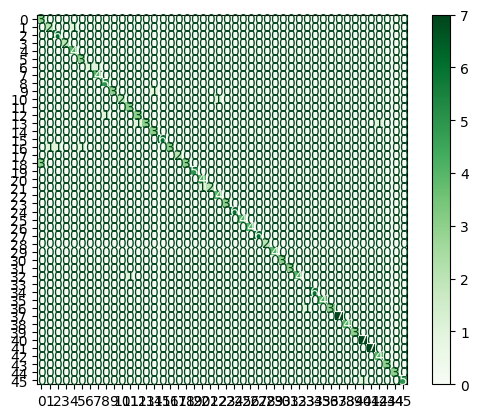

In [ ]:
conf_m = confusion_matrix(ytrue, yhat)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_m, display_labels=actions)
disp.plot(cmap=plt.conf_m.Greens, xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()

In [30]:
accuracy_score(ytrue, yhat)

0.9095744680851063

In [ ]:
sequence = []
sentence = []
predictions = []
threshold = 0.6

video = cv2.VideoCapture(0)

with mp_hands.Hands(
    max_num_hands=2,
    min_det=0.7,
    min_track=0.7
) as hands:
    while video.isOpened():

        ret, frame = video.read()

        image, results = mp_detect(frame, hands)
        print(results)
        if results.multi_hand_landmarks:
            for hand_landmarks in results.multi_hand_landmarks:
                mp_draw.draw_landmarks(
                    image,
                    hand_landmarks,
                    mp_hands.HAND_CONNECTIONS)
    
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-30:]
        
        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            predictions.append(np.argmax(res))
            if np.unique(predictions[-10:])[0]==np.argmax(res): 
                if res[np.argmax(res)] > threshold:     
                    if len(sentence) > 0: 
                        if actions[np.argmax(res)] != sentence[-1]:
                            sentence.append(actions[np.argmax(res)])
                    else:
                        sentence.append(actions[np.argmax(res)])
            if len(sentence) > 3: 
                            sentence = sentence[-3:]

            cv2.putText(image, ' '.join(sentence), (3,30), 
                        cv2.FONT_ITALIC, 1, (255, 255, 255), 2, cv2.LINE_AA)
            cv2.imshow('OpenCV Feed', image)
            if cv2.waitKey(10) & 0xFF == ord('q'):
                break
    video.release()
    cv2.destroyAllWindows()